In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
%matplotlib inline

In [2]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

print(__version__)

4.5.0


In [3]:
import cufflinks as cf

In [4]:
init_notebook_mode(connected=True)

In [5]:
cf.go_offline()

In [6]:
ch = pd.read_csv('games.csv')

In [7]:
pd.set_option('display.max_columns',None)

In [8]:
ch.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


# Firstly, We will see which camp has higher rate of winning.

white    10001
black     9107
draw       950
Name: winner, dtype: int64

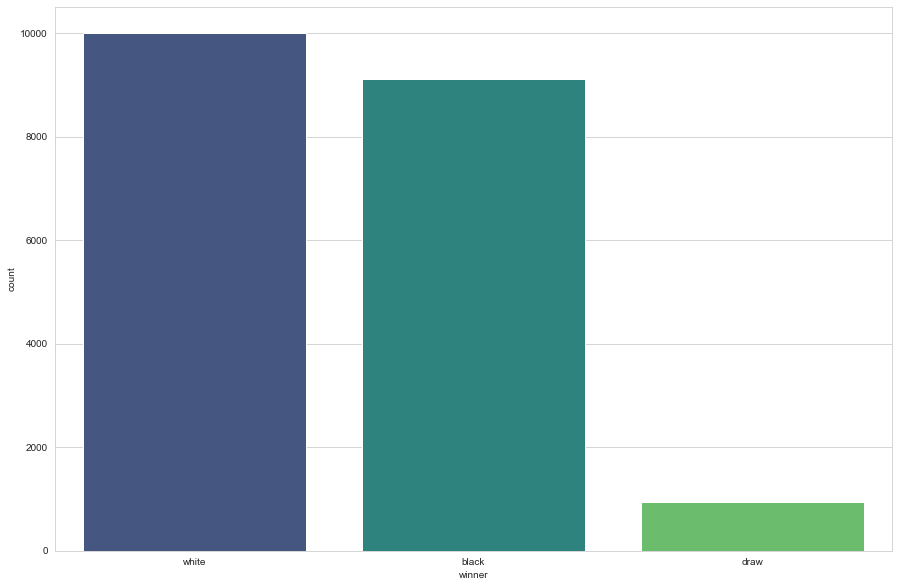

In [9]:
plt.figure(figsize=(15,10))
sns.countplot(x='winner',data=ch,palette='viridis')
ch['winner'].value_counts()

In [10]:
print(10001/(9107+10001))

0.5233933431023655


# So we see white camp has 52.34% of winning rate against black camp maybe because of its advanatage of the right of preoccupation, we will see if there is other reason behind it.

In [11]:
def f(x):
    if x['white_rating'] > x['black_rating']:
        return 0
    elif x['white_rating']< x['black_rating']:
        return 1
    else:
        return 2
ch['higher_rating']=ch.apply(f,axis=1)

0.6514025539041239

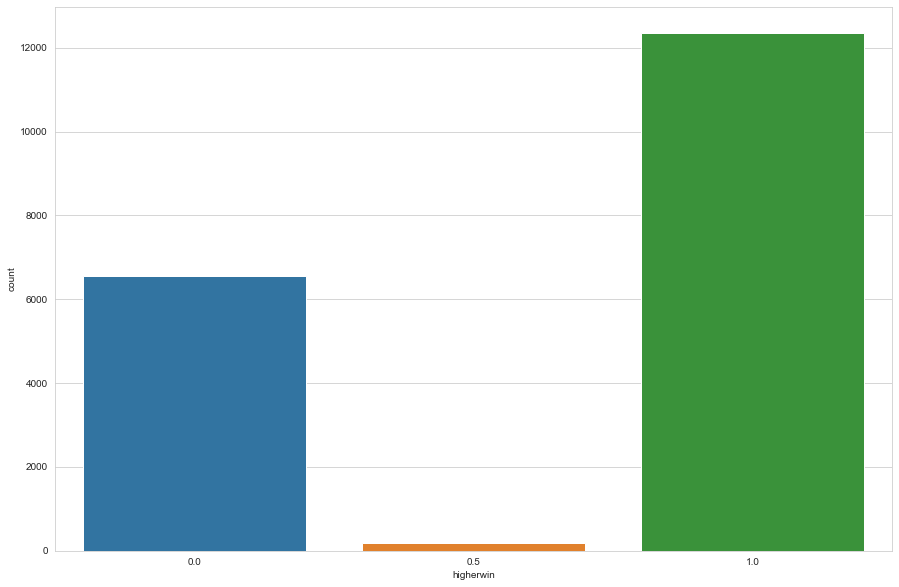

In [12]:
ch.loc[(ch['winner'] == 'black') & (ch['higher_rating'] == 1), 'higherwin'] = 1   
ch.loc[(ch['winner'] == 'white') & (ch['higher_rating'] == 0), 'higherwin'] = 1  
ch.loc[(ch['winner'] == 'white') & (ch['higher_rating'] == 2), 'higherwin'] = 0.5
ch.loc[(ch['winner'] == 'black') & (ch['higher_rating'] == 2), 'higherwin'] = 0.5
ch.loc[(ch['winner'] == 'black') & (ch['higher_rating'] == 0), 'higherwin'] = 0
ch.loc[(ch['winner'] == 'white') & (ch['higher_rating'] == 1), 'higherwin'] = 0
plt.figure(figsize=(15,10))
sns.countplot(x='higherwin',data=ch)
ch['higherwin'].mean()

So, we can see if there is a matchup on higher rating player vs lower rating player, higher rating player has winning rate as 65.14%

# Now, Let's look up a distribution of rating differences in games, and how is that affect the result.

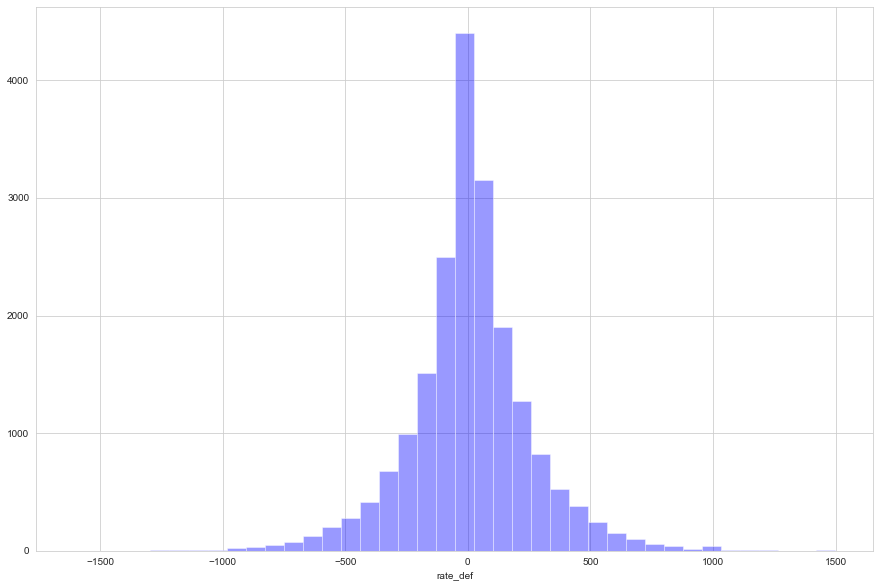

In [13]:
ch.loc[(ch['white_rating'] > ch['black_rating']), 'rate_def'] = (ch['white_rating'] - ch['black_rating'])
ch.loc[(ch['white_rating'] < ch['black_rating']), 'rate_def'] = (ch['white_rating'] - ch['black_rating'])
ch.loc[(ch['white_rating'] == ch['black_rating']), 'rate_def'] = 0
plt.figure(figsize=(15,10))
sns.distplot(ch['rate_def'], kde=False, bins=40, color='Blue')

In [14]:
def f(x):
    if x['rate_def'] > 0:
        return 1
    elif x['rate_def'] < 0:
        return -1
    else:
        return 0
ch['wtbl']=ch.apply(f,axis=1)
ch['wtbl'].mean()

0.02557583009273108

# so, 2.56*2 = 5.12% more like a higher player to be white camp. Thus, result we had earlier on white camp's winning rate could be affected by this reason too.

In [15]:
ch.loc[(ch['winner'] == 'white'), 'win_num'] = 1  
ch.loc[(ch['winner'] == 'black'), 'win_num'] = -1
ch.loc[(ch['winner'] == 'draw'), 'win_num'] = 0

In [16]:
h = ch.groupby(ch['rate_def'])['win_num'].mean()
ch['win_rt'] = h

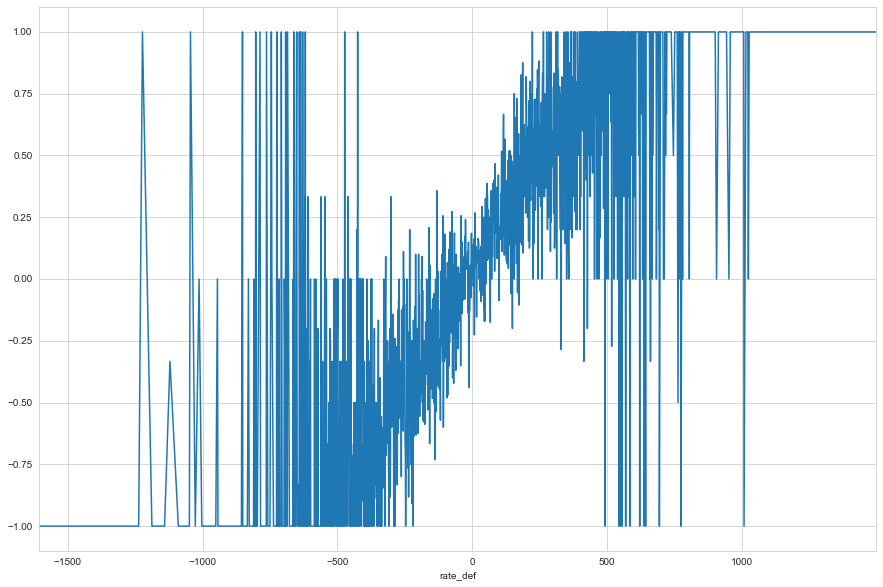

In [17]:
h.plot(kind="line",grid=True,figsize=(15,10))

# We can see there are correlation between amount of rating differences and winning rate as it form a slope line through (blackhigh-blackwin, whitehigh-whitewin)

# now, let's figure which opening move is the most effective to win a chess game

In [18]:
op = ch.groupby(ch['opening_name'])['win_num'].mean()
opsz=ch.groupby(ch['opening_name']).size()

opp = op[opsz >= 10]
wh_opp = opp.nlargest(10)
bk_opp = opp.nsmallest(10)
wh_opp, bk_opp

(opening_name
 King's Pawn                                                         0.888889
 Polish Defense                                                      0.714286
 Italian Game: Two Knights Defense |  Knight Attack                  0.687500
 Zukertort Opening: Ross Gambit                                      0.647059
 Ruy Lopez: Berlin Defense                                           0.642857
 Zukertort Opening: Slav Invitation                                  0.636364
 Nimzowitsch Defense: Scandinavian Variation |  Advance Variation    0.625000
 Sicilian Defense: Open                                              0.625000
 Danish Gambit Accepted |  Classical Defense                         0.600000
 Queen's Gambit Accepted: Rosenthal Variation                        0.600000
 Name: win_num, dtype: float64, opening_name
 Scandinavian Defense: Panov Transfer                   -1.000000
 Queen's Pawn Game: Colle System |  Anti-Colle          -0.800000
 Budapest Defense: Adler Vari

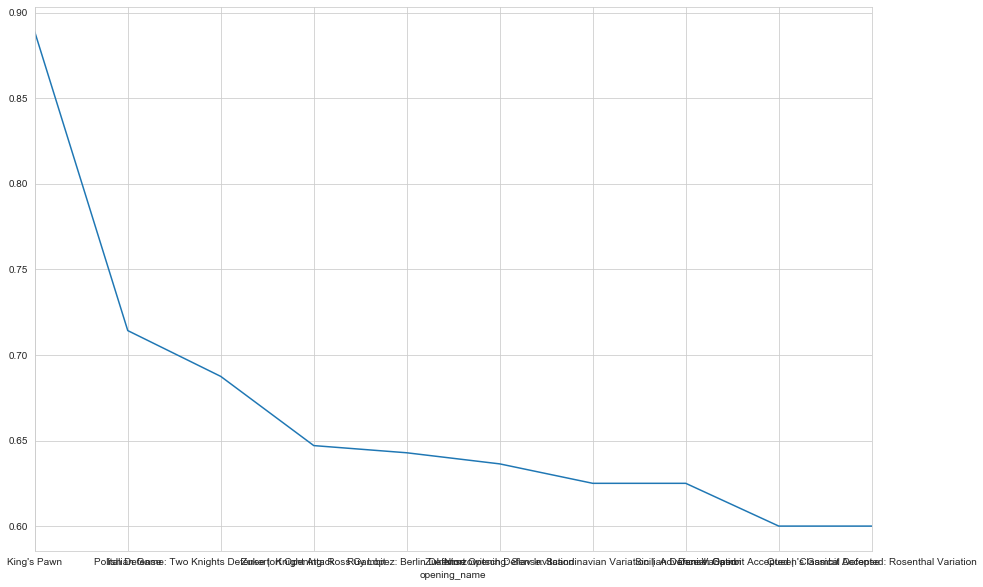

In [19]:
wh_opp.plot(figsize=(15,10))

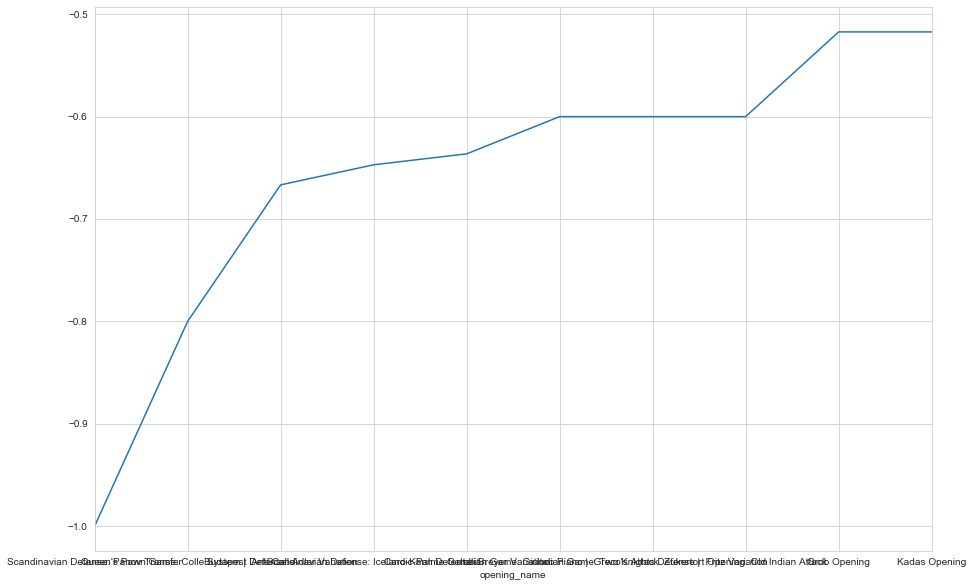

In [20]:
bk_opp.plot(figsize=(15,10))

In [21]:
ch['open'] = ch['opening_name'].apply(lambda opening_name: opening_name.split(':')[0]).apply(lambda opening_name: opening_name.split('|')[0])
open_gr = ch.groupby(ch['open'])['win_num'].mean()
open_sz = ch.groupby(ch['open']).size()

open_category = open_gr[open_sz >= 10]
wh_op = open_category.nlargest(10) 
bk_op = open_category.nsmallest(10)
wh_op, bk_op

(open
 King's Pawn                0.888889
 Polish Defense             0.714286
 Englund Gambit Complex     0.666667
 Danish Gambit Accepted     0.555556
 Pirc Defense #5            0.511628
 Danish Gambit Accepted     0.454545
 Gunderam Defense           0.454545
 Barnes Defense             0.437500
 Queen's Gambit             0.428571
 Goldsmith Defense          0.411765
 Name: win_num, dtype: float64, open
 Budapest Defense         -0.600000
 Kadas Opening            -0.517241
 Richter-Veresov Attack   -0.500000
 London System            -0.450000
 Grob Opening             -0.405405
 Torre Attack #2          -0.375000
 King's Gambit Accepted   -0.300000
 Van't Kruijs Opening     -0.271739
 Center Game              -0.254545
 King's Pawn Opening      -0.230769
 Name: win_num, dtype: float64)

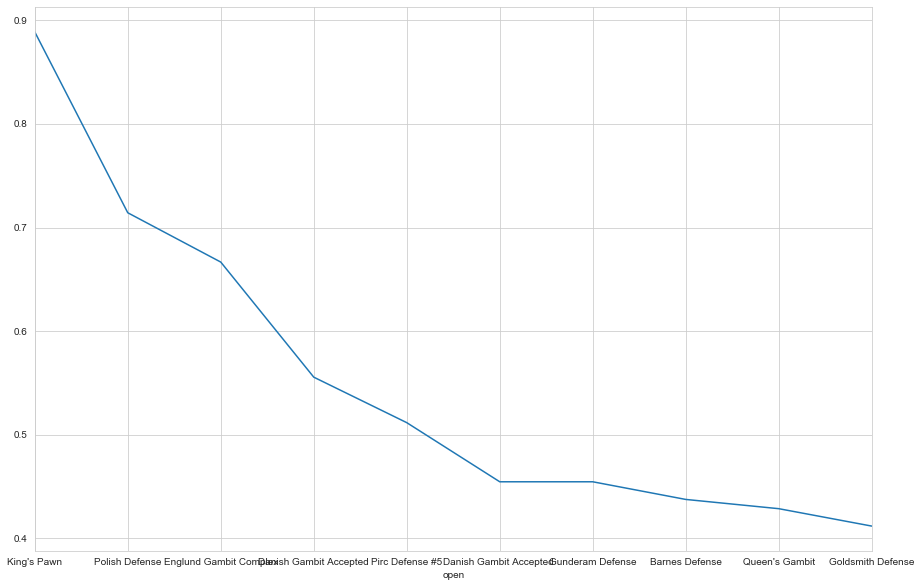

In [22]:
wh_op.plot(figsize=(15,10))

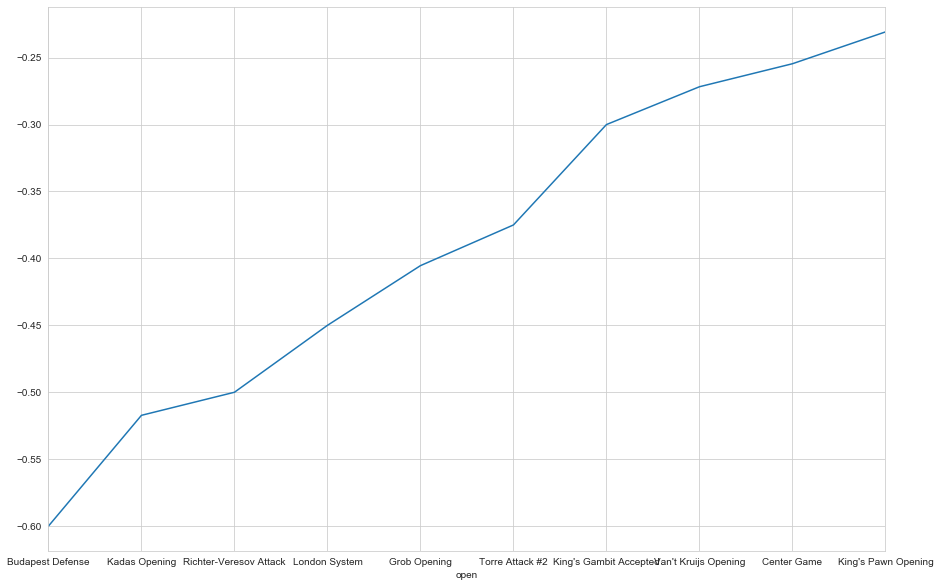

In [23]:
bk_op.plot(figsize=(15,10))

# Therefore, 'King's Pawn' is the best opening for white camp as it guarantees the highest win rate in whole opening move and 'Scandinavian Defense: Panov Transfer ' is the best opening for black camp. if we use comprehensive terms for opening, then 'Budapest Defense' is the best opening for black camp.

# Let's now analyze if there is correlation between how many turns they takes to win and how high their rating is

In [24]:
ch['avg_rate'] = ((ch['black_rating']+ch['white_rating'])/2)
ch.loc[(ch['winner'] == 'white'), 'winner_rt'] = ch['white_rating']
ch.loc[(ch['winner'] == 'black'), 'winner_rt'] = ch['black_rating']
ch.loc[(ch['winner'] == 'draw'), 'winner_rt'] = ch['avg_rate']

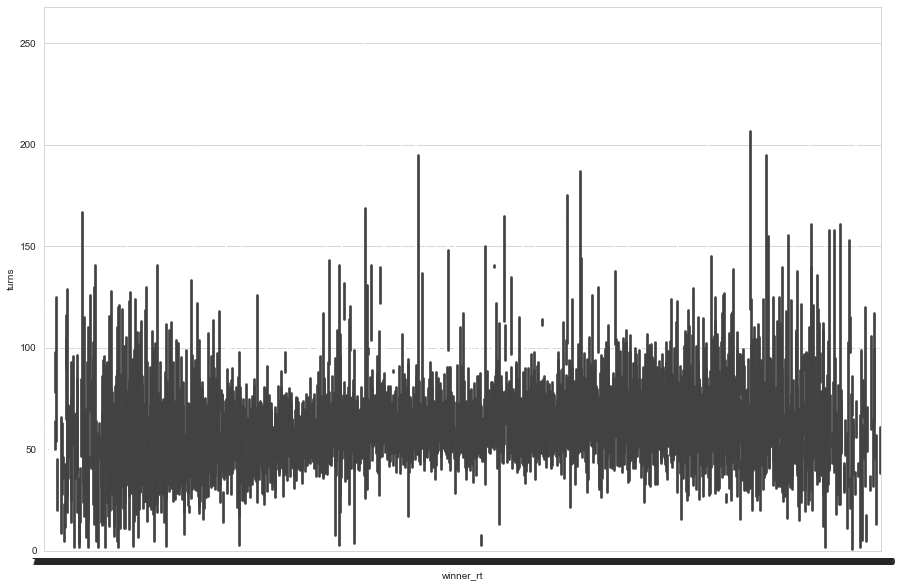

In [25]:
plt.figure(figsize=(15,10))
sns.barplot(x='winner_rt',y='turns',data=ch,saturation=0.2)

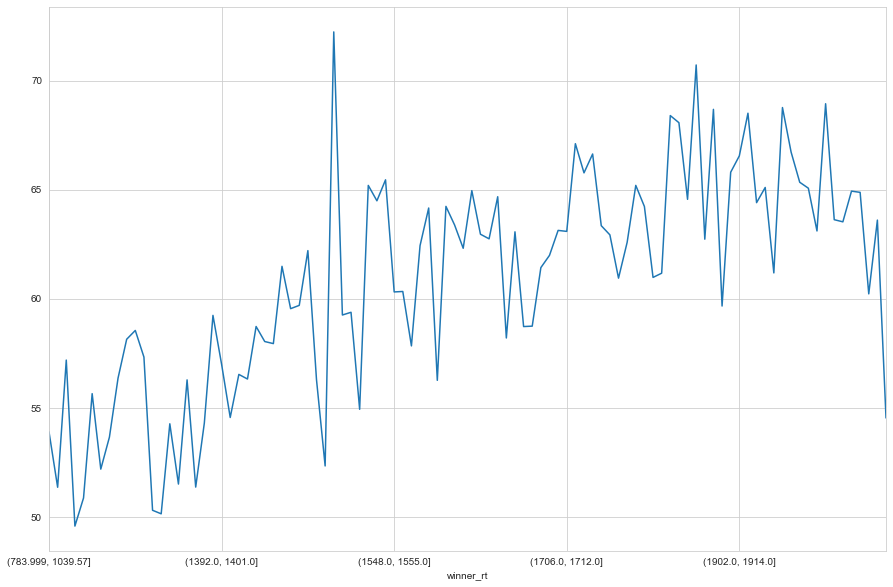

In [26]:
avg_turn1 = ch.groupby(pd.qcut(ch['winner_rt'],q=100,duplicates='drop'))['turns'].mean()
plt.figure(figsize=(15,10))
avg_turn1.plot()

# we see that it has tendency average turns are incresing as higher winner's rating. let's see if this match with average rating of both players.

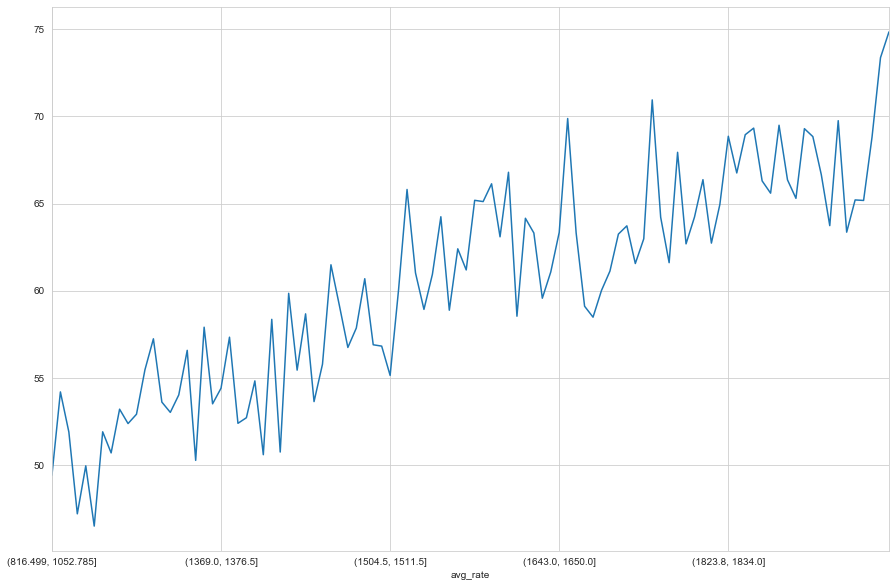

In [27]:
avg_turn2 = ch.groupby(pd.qcut(ch['avg_rate'],q=100,duplicates='drop'))['turns'].mean()
plt.figure(figsize=(15,10))
avg_turn2.plot()

# Thus, we can see if both player are more skilled, then games tend to last longer as it also match with previous graph.

# Then, now we will figure what happens on how many turns till game ends when both player's rating differences increases

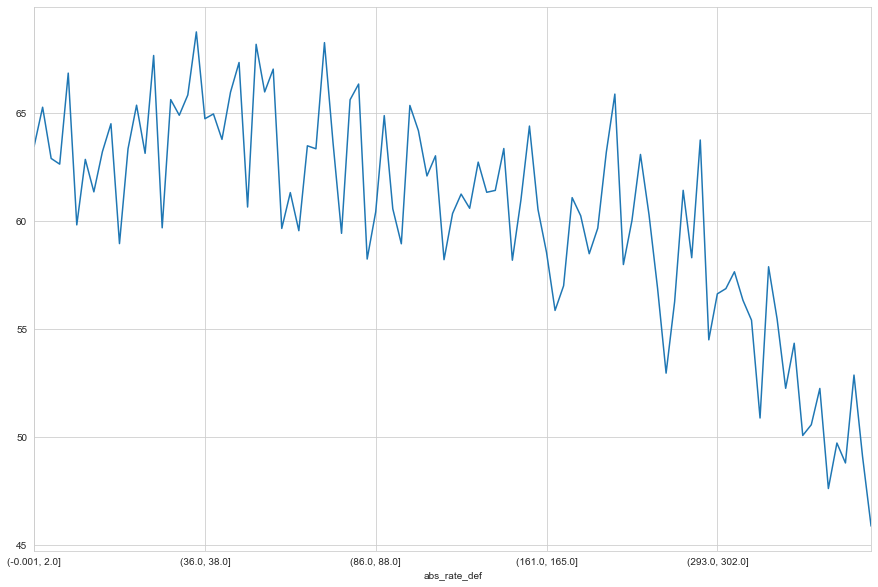

In [28]:
ch['abs_rate_def'] = abs(ch['rate_def'])
avg_turn3 = ch.groupby(pd.qcut(ch['abs_rate_def'],q=100,duplicates='drop'))['turns'].mean()
plt.figure(figsize=(15,10))
avg_turn3.plot()

# This graph shows when incresing rating differences between two players, it tends not to take a game last longer.

# Then, see if there is correlation between higher rating to be more likely white camp or black camp.

In [29]:
set(ch['victory_status'])

{'draw', 'mate', 'outoftime', 'resign'}

(<matplotlib.axes._subplots.AxesSubplot at 0x2034ba8edc8>, victory_status
 draw           906
 mate          6325
 outoftime     1680
 resign       11147
 dtype: int64)

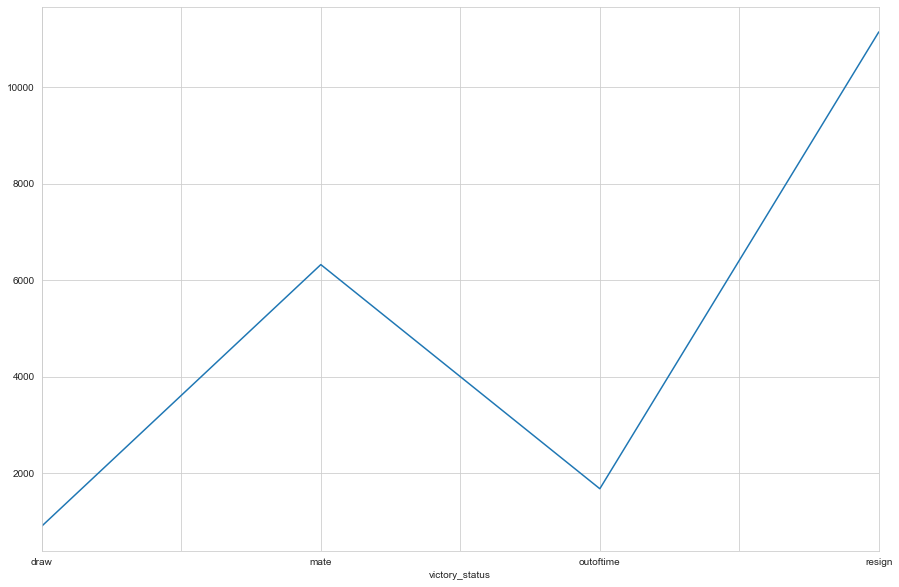

In [120]:
vs = ch.groupby(ch['victory_status']).size()
plt.figure(figsize=(15,10))
vs.plot() , vs

# the most reason defeated is losing player's resign

# now we will see if there are relationships between number of games played vs rating.

In [137]:
mostwt=ch.groupby(ch['white_id']).size().fillna(0)
mostwt_rt=ch.groupby(ch['white_id'])['white_rating'].mean().fillna(0)
mostwt,mostwt_rt

(white_id
 --jim--                1
 -l-_jedi_knight_-l-    6
 -mati-                 1
 -pavel-                1
 1063314                1
                       ..
 zynko                  4
 zzeecco                1
 zztopillo              1
 zzzbbb                 1
 zzzimon                1
 Length: 9438, dtype: int64, white_id
 --jim--                 986.000000
 -l-_jedi_knight_-l-    1499.833333
 -mati-                 1252.000000
 -pavel-                1383.000000
 1063314                1666.000000
                           ...     
 zynko                  1504.000000
 zzeecco                1525.000000
 zztopillo              1466.000000
 zzzbbb                 1616.000000
 zzzimon                1375.000000
 Name: white_rating, Length: 9438, dtype: float64)

In [140]:
mostbk=ch.groupby(ch['black_id']).size().fillna(0)
mostbk_rt=ch.groupby(ch['black_id'])['black_rating'].mean().fillna(0)

C:\Users\Banggu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\Banggu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




'sort=True'

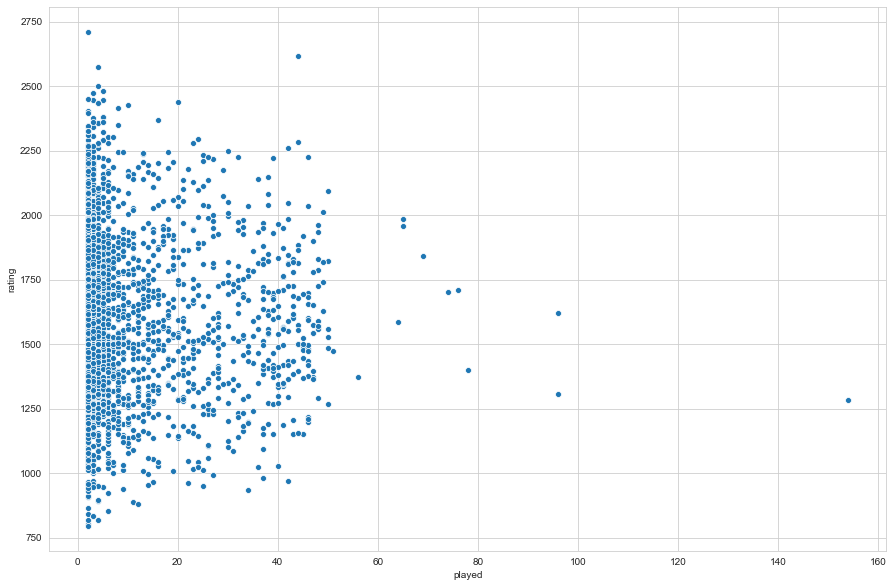

In [266]:
most = pd.concat([mostwt , mostbk],axis=1,ignore_index=True).fillna(0)
most1=most.rename(columns={0: "a", 1: "c"})
most1['played'] = most1['a']+most1['c']
df1 = pd.concat([mostwt_rt,mostbk_rt],axis=1).fillna(0)
df1.loc[(df1['white_rating'] == 0), 'z'] = (df1['black_rating']+df1['white_rating'])
df1.loc[(df1['black_rating'] == 0), 'z'] = (df1['black_rating']+df1['white_rating'])
df1.loc[(df1['black_rating'] != 0) & (df1['white_rating'] != 0), 'rating'] = (df1['black_rating']+df1['white_rating'])/2
df = pd.concat([most1,df1],axis=1)
plt.figure(figsize=(15,10))
sns.scatterplot(x='played', y='rating',data=df)

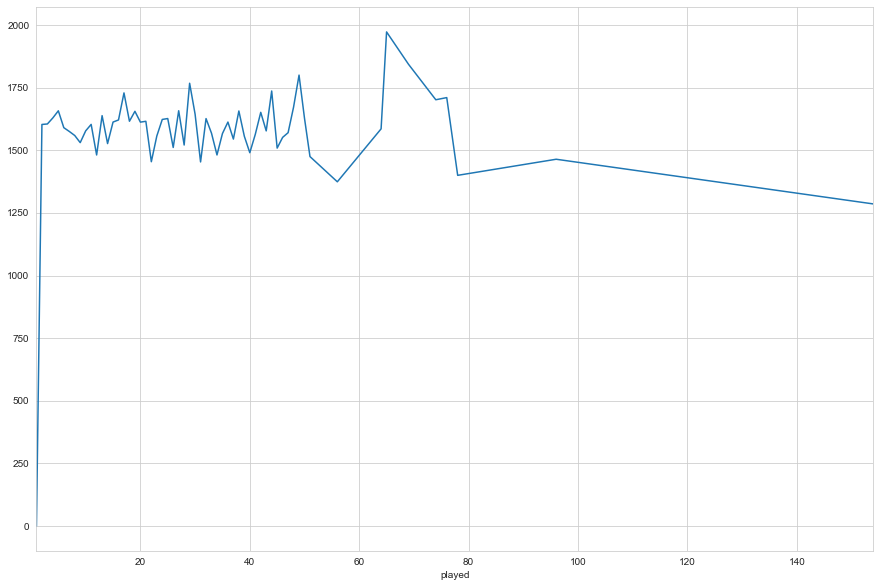

In [272]:
df_g=df.groupby(df['played'])['rating'].mean().fillna(0)
plt.figure(figsize=(15,10))
df_g.plot()

# We can see that there is no strong relation how many games they played with their rating score